In [1]:
import pandas as pd
import numpy as np
from dateutil import parser
import duckdb as db

from matplotlib import pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA

In [2]:
data = pd.read_csv("financial_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1000 non-null   object
 1   Revenue   1000 non-null   int64 
 2   Expenses  1000 non-null   int64 
 3   Profit    1000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.4+ KB


In [3]:
data["Date"] = data["Date"].map(parser.parse)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1000 non-null   datetime64[ns]
 1   Revenue   1000 non-null   int64         
 2   Expenses  1000 non-null   int64         
 3   Profit    1000 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 31.4 KB


Analisis Statistik pada Data

In [4]:
data.describe(include='all')

,Date,Revenue,Expenses,Profit
count,1000,1000.000000,1000.000000,1000.000000
mean,2023-06-29 16:06:14.400000,12311.360000,5979.476000,6331.884000
min,2023-01-02 00:00:00,5023.000000,2004.000000,-4022.000000
25%,2023-03-20 18:00:00,8472.750000,3868.750000,2584.000000
50%,2023-07-03 00:00:00,12179.500000,5965.000000,6286.000000
75%,2023-10-06 06:00:00,15959.750000,8188.500000,10029.750000
max,2023-12-30 00:00:00,19989.000000,9999.000000,17869.000000
std,NaN,4362.996684,2342.899236,4969.539125


Perkembangan Pendapatan (Revenue) dan Laba (Profit)

In [5]:
data.head()

,Date,Revenue,Expenses,Profit
0,2023-07-23,6779,9187,-2408
1,2023-11-11,15221,7708,7513
2,2023-12-07,8686,8693,-7
3,2023-05-01,5711,4666,1045
4,2023-01-18,6852,9987,-3135


In [6]:
data_new = data.sort_values(by='Date')
data_new.head()

,Date,Revenue,Expenses,Profit
710,2023-01-02,19300,4325,14975
107,2023-01-02,8219,5555,2664
761,2023-01-03,9270,6142,3128
493,2023-01-03,8199,3975,4224
262,2023-01-03,7169,3169,4000


In [7]:
def query(sql_query:str) -> pd.DataFrame:
    return db.sql(sql_query).df()

In [8]:
sum_col = ", ".join([f'SUM("{col}") AS "{col}"' for col in data_new.iloc[:, 1:]])

x = query(f'''SELECT MONTH(Date) AS Month, {sum_col} FROM data_new
            GROUP BY MONTH(Date) ORDER BY MONTH(Date)''')
x

,Month,Revenue,Expenses,Profit
0,1,1296287.0,629845.0,666442.0
1,2,971880.0,463243.0,508637.0
2,3,1068769.0,499683.0,569086.0
3,4,1011152.0,466250.0,544902.0
4,5,952889.0,491328.0,461561.0
5,6,735624.0,368634.0,366990.0
6,7,1063433.0,527562.0,535871.0
7,8,984361.0,480289.0,504072.0
8,9,910322.0,445481.0,464841.0
9,10,1085513.0,489586.0,595927.0


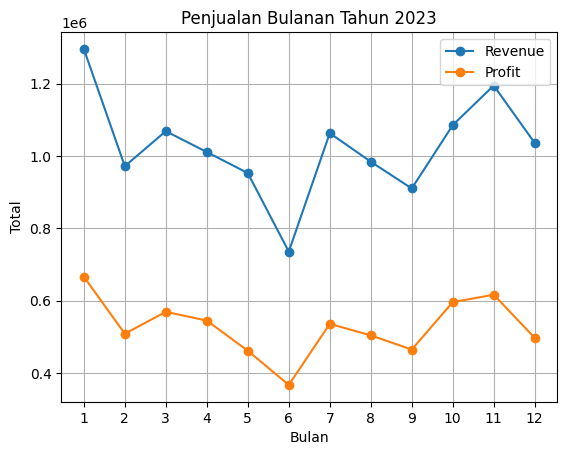

In [9]:
plt.plot(x['Month'], x[['Revenue', 'Profit']], marker='o')

plt.title('Penjualan Bulanan Tahun 2023')
plt.xticks(x['Month'])
plt.xlabel('Bulan')
plt.ylabel('Total')
plt.legend(x[['Revenue', 'Profit']])
plt.grid(True)

plt.show()

Rasio laba (Profit) Terhadap Biaya (Expenses) Setiap Bulan

In [10]:
x['Rasio Laba (%)'] = (x['Profit']/x['Expenses'])*100
x

,Month,Revenue,Expenses,Profit,Rasio Laba (%)
0,1,1296287.0,629845.0,666442.0,105.810477
1,2,971880.0,463243.0,508637.0,109.799177
2,3,1068769.0,499683.0,569086.0,113.889406
3,4,1011152.0,466250.0,544902.0,116.869062
4,5,952889.0,491328.0,461561.0,93.941522
5,6,735624.0,368634.0,366990.0,99.554029
6,7,1063433.0,527562.0,535871.0,101.574981
7,8,984361.0,480289.0,504072.0,104.951810
8,9,910322.0,445481.0,464841.0,104.345864
9,10,1085513.0,489586.0,595927.0,121.720597


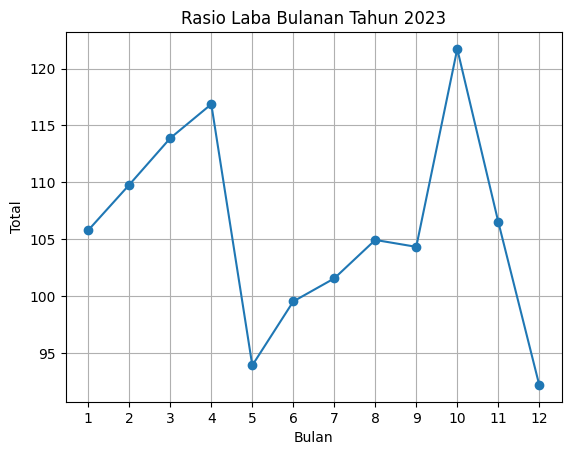

In [11]:
plt.plot(x['Month'], x['Rasio Laba (%)'], marker='o')

plt.title('Rasio Laba Bulanan Tahun 2023')
plt.xticks(x['Month'])
plt.xlabel('Bulan')
plt.ylabel('Total')
plt.grid(True)

plt.show()

Analisis Bulan ke-? dengan Laba Tertinggi dan Terendah

In [12]:
high = x.loc[x['Rasio Laba (%)'].idxmax(), ['Month','Rasio Laba (%)']]
print(f'Laba bersih tertinggi ada di bulan {high['Month']}, sebesar {high['Rasio Laba (%)']}')

Laba bersih tertinggi ada di bulan 10.0, sebesar 121.72059658568668


In [13]:
low = x.loc[x['Rasio Laba (%)'].idxmin(), ['Month','Rasio Laba (%)']]
print(f'Laba bersih tertinggi ada di bulan {low['Month']}, sebesar {low['Rasio Laba (%)']}')

Laba bersih tertinggi ada di bulan 12.0, sebesar 92.2234755859991


Membuat Model Sederhana untuk Memprediksi Pendapatan (Revenue) Berdasarkan Biaya (Expenses)

In [14]:
exs = x['Expenses'].values.reshape(-1,1)    #var x
rev = x['Revenue']                          #var y -> tujuan prediksi

model = LinearRegression()  #pembuatan model
model.fit(exs, rev)         #pelatihan model

#evaluasi model
print(f'Koefisien\t: {model.coef_}')
print(f'Intersep\t: {model.intercept_}')
print(f'r^2 Score\t: {r2_score(rev, model.predict(exs))}')

Koefisien	: [2.00873806]
Intersep	: 25013.2485865138
r^2 Score	: 0.9055178394228562


Prediksi Pendapatan (Revenue) Berdasarkan Biaya (Expenses) dari Model yang Telah Dibuat

In [15]:
#tidak melalui input (lebih dari satu)
model.predict([[463243], [629845.0]])

array([ 955547.09347534, 1290206.87166123])

In [16]:
#melalui input (tunggal)
y = float(input("Masukkan besar biaya: "))
print(f"Perkiraan pendapatan dengan biaya sebesar {y}: {model.predict([[y]])[0]}")

Perkiraan pendapatan dengan biaya sebesar 729845.0: 1491080.6776094765


In [17]:
#melalui input (lebih dari satu)
biaya_input = input("Masukkan besar biaya: ")

biaya_list = biaya_input.split()

biaya_int = [float(x) for x in biaya_list]

for z in biaya_int:
    print(f"Perkiraan pendapatan dengan biaya sebesar {z}: {model.predict([[z]])[0]}")

Perkiraan pendapatan dengan biaya sebesar 463243.5: 955548.0978443683
Perkiraan pendapatan dengan biaya sebesar 629845.9: 1290208.679525486


Koefisien Korelasi Antara Pendapatan (Revenue) dan Laba (Profit)

In [18]:
x[['Revenue','Profit']].corr()

,Revenue,Profit
Revenue,1.000000,0.966603
Profit,0.966603,1.000000


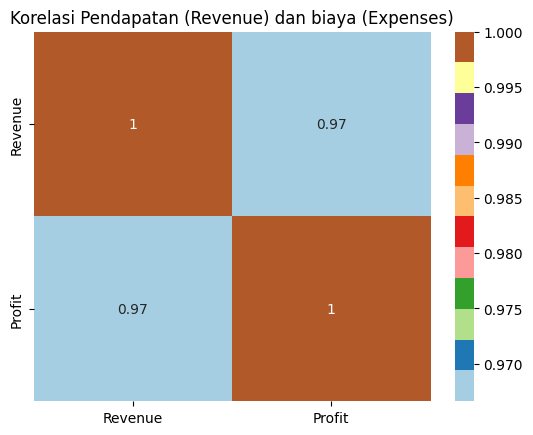

In [19]:
sns.heatmap(x[['Revenue', 'Profit']].corr(), annot=True, cmap='Paired')
plt.title('Korelasi Pendapatan (Revenue) dan biaya (Expenses)')
plt.show()

Identifikasi Outlier pada Data Pendapatan (Revenue) dan biaya (Expenses)

In [20]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Box(y=x['Expenses'], name='Expenses'), row=1, col=1)
fig.add_trace(go.Box(y=x['Revenue'], name='Revenue'), row=1, col=1)

scatter_trendline = px.scatter(x, x="Expenses", y="Revenue", trendline="ols", trendline_color_override="orange")['data'][1]
fig.add_trace(go.Scatter(x=x["Expenses"], y=x["Revenue"], mode="markers", name="Expenses vs Revenue"), row=1, col=2)
fig.add_trace(scatter_trendline, row=1, col=2)

fig.write_html("g_4.html")
fig.show()

In [21]:
x.describe(include='all')

,Month,Revenue,Expenses,Profit,Rasio Laba (%)
count,12.000000,1.200000e+01,12.000000,12.000000,12.000000
mean,6.500000,1.025947e+06,498289.666667,527657.000000,105.935837
std,3.605551,1.402715e+05,66449.951392,79700.318477,8.751127
min,1.000000,7.356240e+05,368634.000000,366990.000000,92.223476
25%,3.750000,9.671322e+05,465498.250000,489019.500000,101.069743
50%,6.500000,1.023612e+06,490457.000000,522254.000000,105.381144
75%,9.250000,1.072955e+06,530420.000000,575796.250000,110.821734
max,12.000000,1.296287e+06,629845.000000,666442.000000,121.720597


Proyeksi Kinerja Keuangan untuk Tahun Berikutnya

In [22]:
month = x['Month'].values.reshape(-1,1) 
rev = x['Revenue']                      

In [23]:
#regresi linear, Model ini menggunakan hubungan linier antara bulan (variabel independen) dan pendapatan (variabel dependen)
model_1 = LinearRegression().fit(month, rev)
next_year_month = np.array([[i] for i in range(13, 25)])
predicted_revenue_model_1 = model_1.predict(next_year_month)

#peramalan arima, Metode ini adalah model statistik yang bergantung pada analisis time series
model_2 = ARIMA(x['Revenue'], order=(1,1,1))
arima_results = model_2.fit()
predicted_revenue_model_2 = arima_results.forecast(steps=12)

print("Proyeksi Kinerja Keuangan Tahun 2024:")
print("--------------------------------")
print("Model Regresi Liniar:")
for month, revenue in enumerate(predicted_revenue_model_1, start=1):
    print(f"Bulan {month}: ${revenue:.2f}")
print("\nMetode Peramalan ARIMA:")
for month, revenue in enumerate(predicted_revenue_model_2, start=1):
    print(f"Bulan {month}: ${revenue:.2f}")    

Proyeksi Kinerja Keuangan Tahun 2024:
--------------------------------
Model Regresi Liniar:
Bulan 1: $1007344.89
Bulan 2: $1004483.08
Bulan 3: $1001621.27
Bulan 4: $998759.46
Bulan 5: $995897.65
Bulan 6: $993035.84
Bulan 7: $990174.03
Bulan 8: $987312.22
Bulan 9: $984450.40
Bulan 10: $981588.59
Bulan 11: $978726.78
Bulan 12: $975864.97

Metode Peramalan ARIMA:
Bulan 1: $1075166.21
Bulan 2: $1071393.59
Bulan 3: $1071757.66
Bulan 4: $1071722.53
Bulan 5: $1071725.92
Bulan 6: $1071725.59
Bulan 7: $1071725.62
Bulan 8: $1071725.62
Bulan 9: $1071725.62
Bulan 10: $1071725.62
Bulan 11: $1071725.62
Bulan 12: $1071725.62


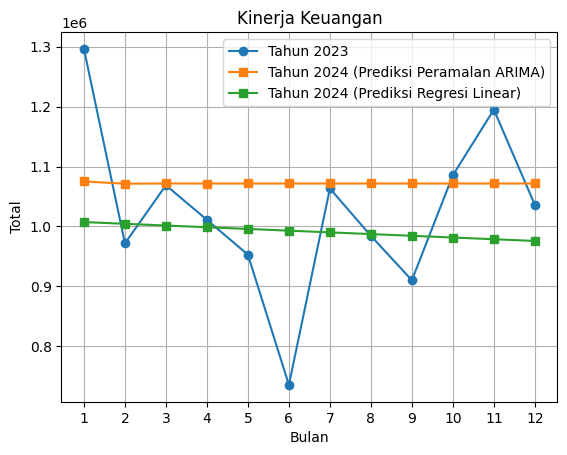

In [24]:
plt.plot(x['Month'], x['Revenue'], marker='o', label='Tahun 2023')
plt.plot(range(1, len(predicted_revenue_model_2) + 1), predicted_revenue_model_2, marker='s', label='Tahun 2024 (Prediksi Peramalan ARIMA)')
plt.plot(range(1, len(predicted_revenue_model_1) + 1), predicted_revenue_model_1, marker='s', label='Tahun 2024 (Prediksi Regresi Linear)')

plt.title('Kinerja Keuangan')
plt.xticks(x['Month'])
plt.xlabel('Bulan')
plt.ylabel('Total')
plt.legend()
plt.grid(True)

plt.show()

Margin Keuntungan (Profit Margin) Setiap Bulan

In [25]:
x['Profit Margin (%)'] = (x['Profit']/x['Revenue'])*100
x

,Month,Revenue,Expenses,Profit,Rasio Laba (%),Profit Margin (%)
0,1,1296287.0,629845.0,666442.0,105.810477,51.411609
1,2,971880.0,463243.0,508637.0,109.799177,52.335371
2,3,1068769.0,499683.0,569086.0,113.889406,53.246866
3,4,1011152.0,466250.0,544902.0,116.869062,53.889227
4,5,952889.0,491328.0,461561.0,93.941522,48.438066
5,6,735624.0,368634.0,366990.0,99.554029,49.888258
6,7,1063433.0,527562.0,535871.0,101.574981,50.390669
7,8,984361.0,480289.0,504072.0,104.951810,51.208043
8,9,910322.0,445481.0,464841.0,104.345864,51.063360
9,10,1085513.0,489586.0,595927.0,121.720597,54.898191


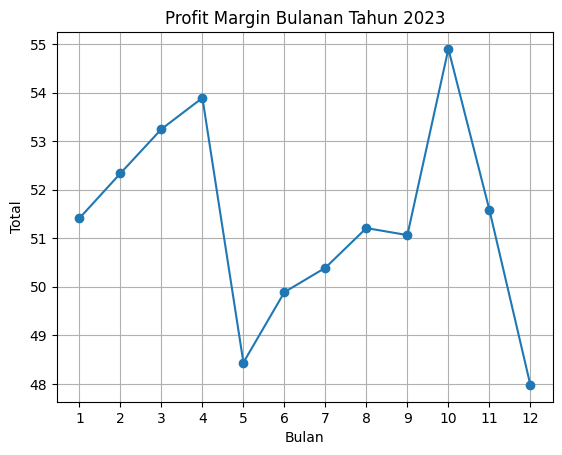

In [26]:
plt.plot(x['Month'], x['Profit Margin (%)'], marker='o')

plt.title('Profit Margin Bulanan Tahun 2023')
plt.xticks(x['Month'])
plt.xlabel('Bulan')
plt.ylabel('Total')
plt.grid(True)

plt.show()